## Vision por computadora 1 - FIUBA
## 17Co2024
## Autores: Joaquín Matías Mestanza, Gonzalo Nicolas Silva Caggiano, Ramiro Andrés Feichubuinm

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
    arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)
    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
    de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
    donde se detecta la condición de máximo enfoque.


### Implementación

In [1]:
import numpy as np
from numpy.fft import fftshift, fft2
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
def image_quality_measure(gray_img):
    m, n = gray_img.shape
    F = fft2(gray_img)
    Fc = fftshift(F)
    AF = np.abs(Fc)
    M = np.max(AF)
    thres = M/1000
    Th = np.sum(AF > thres)
    return Th/(m*n)

### Verificación

In [3]:
def get_gray_img(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                       
lena_gray = get_gray_img(cv2.imread('lena.png'))
lena_gray.shape

(512, 512)

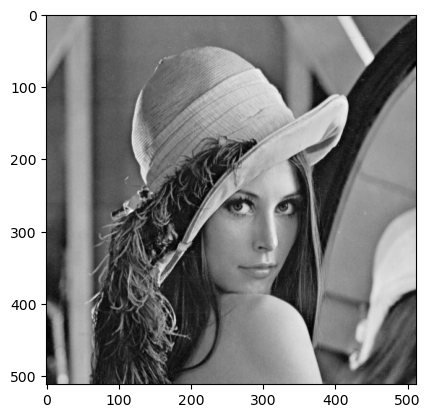

In [4]:
plt.imshow(lena_gray, cmap='gray')

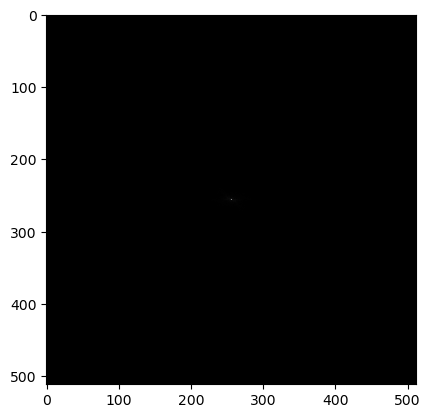

In [5]:
spectrum = np.abs(fftshift(fft2(lena_gray)))
plt.imshow(spectrum, cmap='gray')

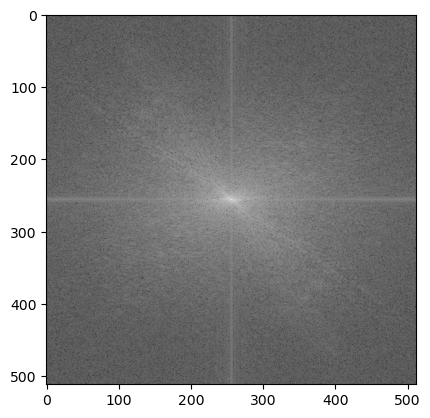

In [6]:
plt.imshow(np.log2(1+abs(spectrum)), cmap='gray')

In [7]:
image_quality_measure(lena_gray)

0.018215179443359375

Este valor coincide con el del trabajo publicado, es decir que el algoritmo se encuentra implementado correctamente.
Sin embargo, se ve que cuando se quiere realizar la estimación del espectro, es distinta a la que se muestra en el paper. Esto puede ser debido a que se utilizó otra imagen de lena (podría ser de menor dimensión) o se realizó una estimación espectral con algun tipo de filtro adicional. 

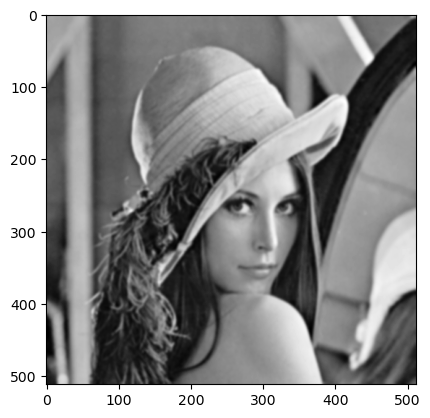

In [8]:
filtered_image = cv2.GaussianBlur(lena_gray, (7,7), 0)
plt.imshow(filtered_image, cmap='gray')

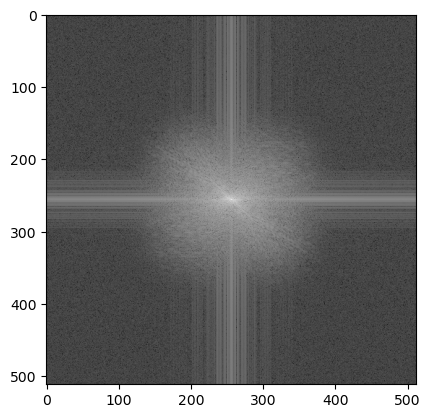

In [9]:
plt.imshow(np.log(1+np.abs(fftshift(fft2(filtered_image)))), cmap='gray')

In [10]:
image_quality_measure(filtered_image)

0.013317108154296875

Aquí se ve que cuando se aplica un GaussianBlur, la métrica disminuye, lo cual también es un comportamiento esperado.

### 1.1.

In [11]:
video = cv2.VideoCapture('focus_video.MOV')
fps = round(video.get(cv2.CAP_PROP_FPS))

In [12]:
def store_frames(vid):
    count = 0
    success = 1
    while success: 
        success, image = vid.read() 
        cv2.imwrite(f'frames/frame-{count:03}.jpg', image) 
        count += 1

In [13]:
# solo se necesita una vez, con la carpeta 'frames' creada, sino no funciona
# store_frames(video)

In [14]:
frame_paths = list(map(lambda x: f'frames/{x}', sorted(os.listdir('frames'))))
frame_paths[:5] # muestra los primeros 5

['frames/frame-000.jpg',
 'frames/frame-001.jpg',
 'frames/frame-002.jpg',
 'frames/frame-003.jpg',
 'frames/frame-004.jpg']

In [15]:
metrics = [image_quality_measure(cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2GRAY)) for frame in frame_paths]

1. Medición sobre todo el frame

In [16]:
def plot_metric(curr_metric):
    plt.plot(curr_metric)
    plt.ylabel('Image Sharpness Measure')
    plt.xlabel('# frame')
    absolute_max = np.max(curr_metric)
    plt.axhline(absolute_max, linestyle='dashed', color='orange', label=f'max: {absolute_max:0.4f}')
    plt.legend()
    return absolute_max

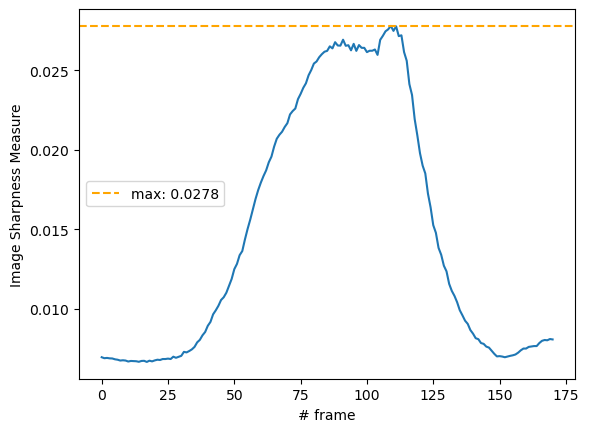

In [17]:
iqm_max = plot_metric(metrics)

 2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del área total del frame.

In [18]:
def get_img_center(img):
    m, n = img.shape
    return m//2, n//2

def get_centered_roi(img, area_percentage):
    m, n = img.shape
    center_m, center_n = get_img_center(img)
    dm, dn = int(m*area_percentage)//2, int(n*area_percentage)//2
    # print(dm,dn)
    return img[center_m-dm:center_m+dm, center_n-dn:center_n+dn]

metrics_roi_5_percent = [image_quality_measure(get_centered_roi(img=get_gray_img(cv2.imread(frame)), area_percentage=0.05)) for frame in frame_paths]

0.96875

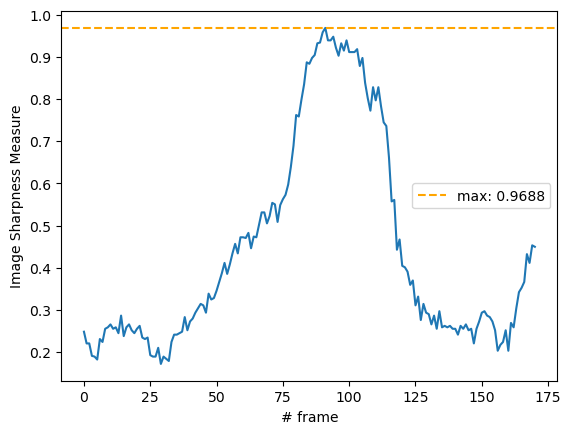

In [19]:
plot_metric(metrics_roi_5_percent)

In [20]:
metrics_roi_10_percent = [image_quality_measure(get_centered_roi(img=get_gray_img(cv2.imread(frame)), area_percentage=0.10)) for frame in frame_paths]

0.75

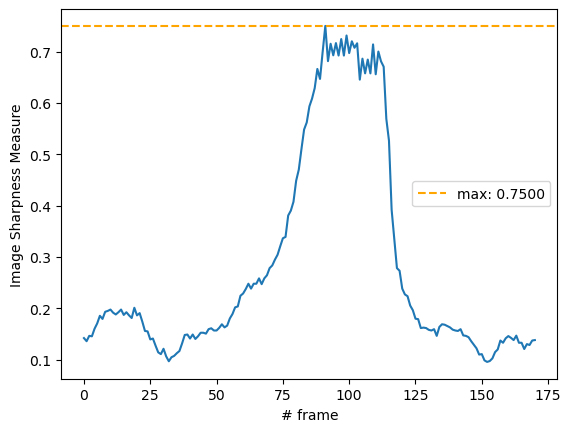

In [21]:
plot_metric(metrics_roi_10_percent)

3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
    arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

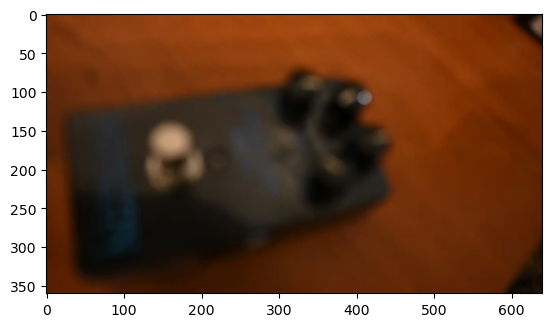

In [22]:
original = cv2.cvtColor(cv2.imread(frame_paths[0]), cv2.COLOR_BGR2RGB)
plt.imshow(original)

In [23]:
def generate_deltas(n):
    return list(range(-(n-1)*2, (n-1)*2+1, 4))
    
def get_focus_matrix(img, rects_i, rects_j, dj, di):
    i,j = get_img_center(img[:,:,0])
    modified_img = img.copy()
    color = (0 , 255, 0) # bgr
    points = []
    for z in generate_deltas(rects_i):
        for k in generate_deltas(rects_j):
            start_point = (j+k*dj-dj, i+z*di-di)
            end_point = (j+k*dj+dj, i+z*di+di)
            points.append((start_point, end_point))
            cv2.rectangle(modified_img, start_point, end_point, color, thickness=2)

    plt.imshow(modified_img)
    return points
    

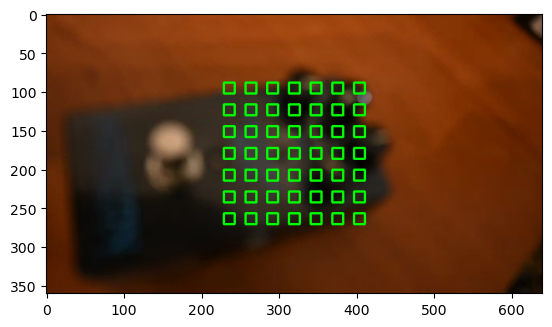

In [24]:
points_7x7 = get_focus_matrix(original, rects_i=7, rects_j=7, dj=7, di=7)

Se verifica que tiene un comportamiento similar a la imagen en la consigna

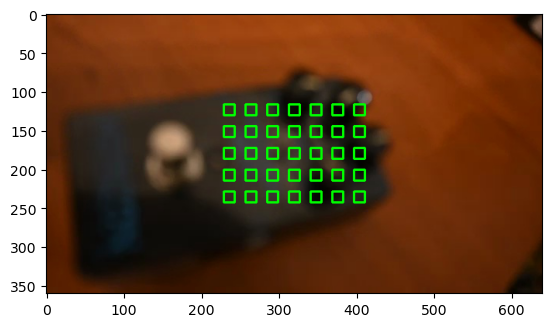

In [25]:
points_5x7 = get_focus_matrix(original, rects_i=5, rects_j=7, dj=7, di=7)

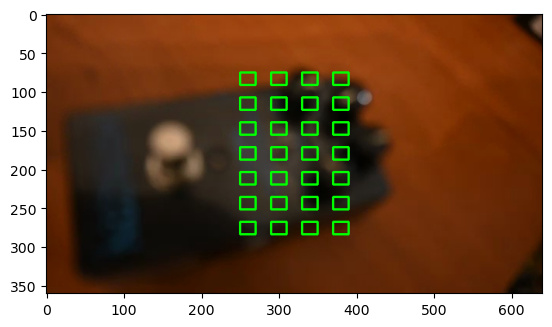

In [26]:
points_7x4 = get_focus_matrix(original, rects_i=7, rects_j=4, dj=10, di=8)

In [27]:
points_7x4[0]

((250, 76), (270, 92))

Ahora que los puntos están definidos, se debe definir un criterio sobre como agrupar por frame el ISM

In [28]:
def get_delta_points(start,end):
    x1,y1 = start
    x2,y2 = end
    dx = x2-x1
    dy = y2-y1
    return x1,y1,dx,dy

def group_metric(img, points):
    # we might want to group by min, max, mean
    gray_img = get_gray_img(img)
    calculations = []
    for start_point, end_point in points:
        x1,y1,dx,dy = get_delta_points(start_point,end_point)
        calculations.append(image_quality_measure(gray_img[y1:y1+dy,x1:x1+dx]))
    return np.mean(calculations)

In [29]:
metrics_7x7 = [group_metric(cv2.imread(frame), points_7x7) for frame in frame_paths]

0.9029571012078302

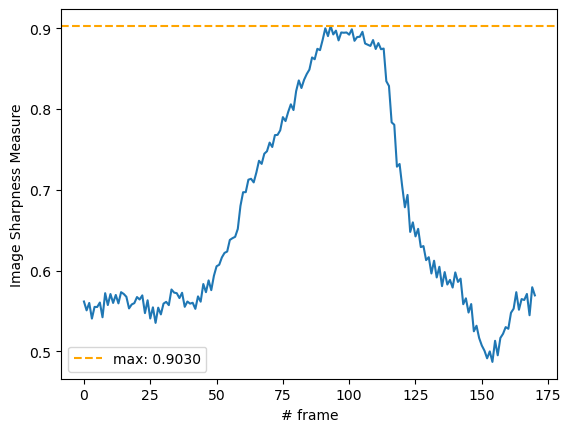

In [30]:
plot_metric(metrics_7x7)

In [31]:
metrics_5x7 = [group_metric(cv2.imread(frame), points_5x7) for frame in frame_paths]

0.9568513119533528

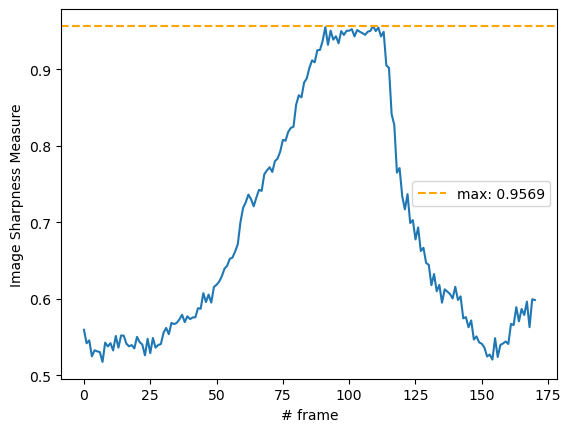

In [32]:
plot_metric(metrics_5x7)

In [33]:
metrics_7x4 = [group_metric(cv2.imread(frame), points_7x4) for frame in frame_paths]

0.8444196428571429

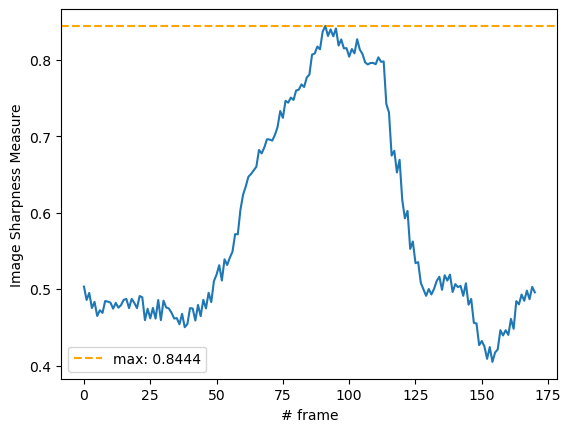

In [34]:
plot_metric(metrics_7x4)

Se define que está enfocado si supera al máximo de la medición en todos los frames.

In [35]:
def draw_focus_matrix(img, threshold, points):
    gray_img = get_gray_img(img)
    modified_img = img.copy()
    green = (0 , 255, 0)
    red = (255, 0, 0)
    calcs = []
    for start_point, end_point in points:
        x1,y1,dx,dy = get_delta_points(start_point,end_point)
        iqm = image_quality_measure(gray_img[y1:y1+dy,x1:x1+dx])
        calcs.append(iqm)
    total_calc = np.mean(calcs)
    # print(total_calc)
    for start_point, end_point in points:
        cv2.rectangle(modified_img, start_point, end_point, green if total_calc > threshold else red, thickness=2)
    return modified_img

In [36]:
print(iqm_max)

0.027799479166666665


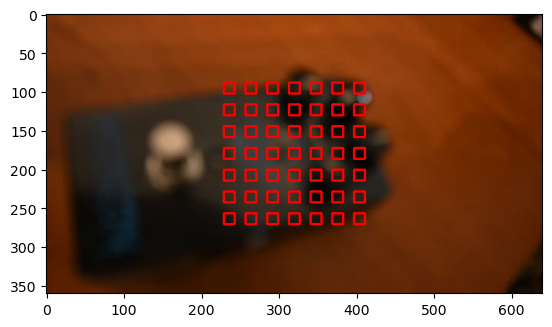

In [37]:
focused_imgs_7x7 = [draw_focus_matrix(cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2RGB), 0.7, points_7x7) for frame in frame_paths]
plt.imshow(focused_imgs_7x7[0])

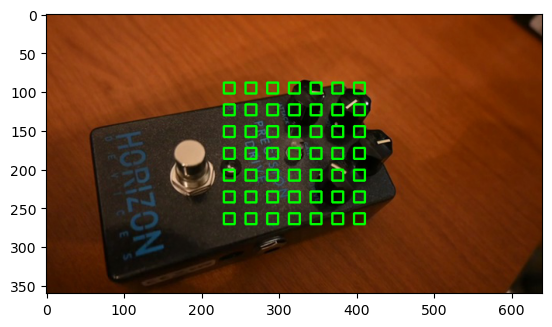

In [38]:
plt.imshow(focused_imgs_7x7[100])

In [47]:
def write_video(filename, rgb_img_list):
    m,n,_ = rgb_img_list[0].shape
    output = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n, m), isColor=True)
    for im in rgb_img_list:
        bgr_im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        output.write(bgr_im)
    video.release()

In [48]:
write_video('output_7x7.mp4', focused_imgs_7x7) 

### 2.

In [55]:

def acmo_focus_measure(gray_img):
    hist, _ = np.histogram(gray_img, bins=256, range=(0, 255))
    mean_intensity = np.mean(hist)
    acmo = np.sum(np.abs(np.arange(256) - mean_intensity) * hist)
    return acmo / gray_img.size

In [56]:
def draw_focus_matrix_2(img, threshold, points):
    gray_img = get_gray_img(img)
    modified_img = img.copy()
    green = (0 , 255, 0)
    red = (255, 0, 0)
    calcs = []
    for start_point, end_point in points:
        x1,y1,dx,dy = get_delta_points(start_point,end_point)
        iqm = acmo_focus_measure(gray_img[y1:y1+dy,x1:x1+dx])
        calcs.append(iqm)
    total_calc = np.mean(calcs)
    # print(total_calc)
    for start_point, end_point in points:
        cv2.rectangle(modified_img, start_point, end_point, green if total_calc > threshold else red, thickness=2)
    return modified_img

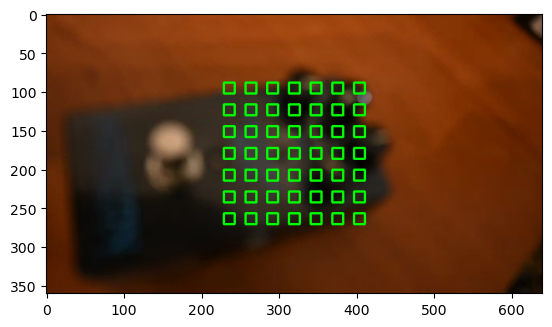

In [57]:
acmo_focus_image = [draw_focus_matrix_2(cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2RGB), 0.7, points_7x7) for frame in frame_paths]
plt.imshow(acmo_focus_image[0])

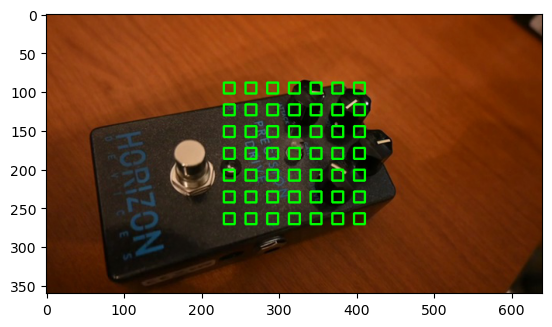

In [53]:
plt.imshow(acmo_focus_image[100])

In [59]:
write_video('output_acmo.mp4', acmo_focus_image) 